Install pytorch! 

In [185]:
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = np.array(Image.open(os.path.join(self.img_dir, self.images[idx])))
        segmentation_map = np.array(Image.open(os.path.join(self.ann_dir, self.annotations[idx])).convert("L"))
        
        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs


In [186]:
from transformers import SegformerImageProcessor

# my_root_dir = ".content/ADE20k_toy_dataset"
my_root_dir = ".content/customDatasetWithLabel"
my_image_processor = SegformerImageProcessor(do_reduce_labels=True) #changed reduce_labels to do_reduce_labels

train_dataset = SemanticSegmentationDataset(root_dir=my_root_dir, image_processor=my_image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=my_root_dir, image_processor=my_image_processor, train=False)

In [187]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))


Number of training examples: 379
Number of validation examples: 48


In [188]:
my_encoded_inputs= train_dataset[0]

In [189]:
my_encoded_inputs["pixel_values"].shape
    

torch.Size([3, 512, 512])

In [190]:
my_encoded_inputs["labels"].shape


torch.Size([512, 512])

In [191]:
my_encoded_inputs["labels"]


tensor([[255, 255, 255,  ...,   7,   7,   7],
        [  1,   1,   1,  ...,   7,   7,   7],
        [  1,   1,   1,  ...,   7,   7,   7],
        ...,
        [  1,   1,   1,  ..., 255, 255, 255],
        [  1,   1,   1,  ..., 255, 255, 255],
        [  1,   1,   1,  ..., 255, 255, 255]])

In [192]:
my_encoded_inputs["labels"].squeeze().unique() #to see unique ids of labels in an image

tensor([  1,   2,   3,   7, 255])

In [193]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8)


In [194]:
batch = next(iter(train_dataloader))


In [195]:
for k2,v2 in batch.items():
  print(k2, v2.shape)

pixel_values torch.Size([8, 3, 512, 512])
labels torch.Size([8, 512, 512])


In [196]:
batch["labels"].shape


torch.Size([8, 512, 512])

In [197]:
mask = (batch["labels"] != 255)
mask


tensor([[[False, False, False,  ..., False, False, False],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [False,  True,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False]],

        [[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [False, False, False,  ..., False,  True,  True],
         [False, False, False,  ..., False,  True,  True],
         [False, False, False,  ..., False, False, False]],

        [[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [

In [198]:
batch["labels"][mask]


tensor([2, 2, 2,  ..., 3, 3, 3])

In [184]:
# #defining the model and labels. 
# 
from transformers import SegformerForSemanticSegmentation
import json

#from huggingface_hub import hf_hub_download
# 
# # load id2label mapping from a JSON on the hub
# repo_id = "huggingface/label-files"
# filename = "ade20k-id2label.json"
# id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {0: 'other', 1: 'Manhole Cover', 2: 'Concrete',3: 'Brick',4: 'Cane', 5: 'Subway grate', 6:'Dirt', 7:'Cellar door', 8:'Tactile pavement'}

with open('cats-and-dogs-id2label.json', 'w') as fp:
    json.dump(id2label, fp)


id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
 
#define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=9,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

#load id2label mapping



Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [163]:
import evaluate
metric = evaluate.load("mean_iou")


In [166]:
import torch
from torch import nn
from tqdm.notebook import tqdm

# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# define optimizer after moving model to GPU
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)

model.train()
for epoch in range(50):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    for idx2, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)

            # note that the metric expects predictions + labels as numpy arrays
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx2 % 100 == 0:
            # compute metrics
            metrics = metric.compute(
                predictions=predicted.cpu(),
                references=labels.cpu(),
                num_labels=len(id2label),
                ignore_index=255,
                reduce_labels=False,  # we've already reduced the labels ourselves
            )
            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])
    torch.save(model.state_dict(), f"models/model_epoch_{epoch}.pth")


Epoch: 0


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 1.3177355527877808
Mean_iou: 0.3561189169315061
Mean accuracy: 0.591020822462304
Epoch: 1


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.6628310680389404
Mean_iou: 0.6281333994366202
Mean accuracy: 0.760955836321654
Epoch: 2


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.44814273715019226
Mean_iou: 0.7434540224864132
Mean accuracy: 0.8459148699010088
Epoch: 3


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.6347023844718933
Mean_iou: 0.7907952231305233
Mean accuracy: 0.8714069972420788
Epoch: 4


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.3392168879508972
Mean_iou: 0.8065513531616606
Mean accuracy: 0.8823675931799467
Epoch: 5


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.2717653810977936
Mean_iou: 0.8571896435011563
Mean accuracy: 0.917715778851965
Epoch: 6


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.2621874511241913
Mean_iou: 0.8580596343003946
Mean accuracy: 0.9188560997493448
Epoch: 7


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.2288518100976944
Mean_iou: 0.8882423586968872
Mean accuracy: 0.9349833437770885
Epoch: 8


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.20702795684337616
Mean_iou: 0.8989513809476688
Mean accuracy: 0.9424628902167683
Epoch: 9


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.17399443686008453
Mean_iou: 0.8987677021264271
Mean accuracy: 0.9436035629905515
Epoch: 10


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.1956184357404709
Mean_iou: 0.9203908603528517
Mean accuracy: 0.9556815451768301
Epoch: 11


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.21967223286628723
Mean_iou: 0.9004600732140539
Mean accuracy: 0.9454350974472792
Epoch: 12


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.39882779121398926
Mean_iou: 0.910421834637421
Mean accuracy: 0.9511027424460335
Epoch: 13


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.11634323000907898
Mean_iou: 0.9113043350237217
Mean accuracy: 0.9502159048967722
Epoch: 14


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.16820107400417328
Mean_iou: 0.927459567447797
Mean accuracy: 0.9625437440530142
Epoch: 15


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.07507719844579697
Mean_iou: 0.9337431670229277
Mean accuracy: 0.9635462767478997
Epoch: 16


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.14256764948368073
Mean_iou: 0.9375007210366584
Mean accuracy: 0.9653823482470377
Epoch: 17


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.07662098854780197
Mean_iou: 0.9340927339552617
Mean accuracy: 0.9640467408516991
Epoch: 18


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.5239514708518982
Mean_iou: 0.9091405792188805
Mean accuracy: 0.9504078102459812
Epoch: 19


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.23468096554279327
Mean_iou: 0.8963889631509248
Mean accuracy: 0.9428973600407855
Epoch: 20


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.07488858699798584
Mean_iou: 0.9261196614042142
Mean accuracy: 0.9584700776432755
Epoch: 21


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.07348591834306717
Mean_iou: 0.9309253069078711
Mean accuracy: 0.9629724566156553
Epoch: 22


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.05870925635099411
Mean_iou: 0.9391724023896916
Mean accuracy: 0.966676647244371
Epoch: 23


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.06375881284475327
Mean_iou: 0.9321068538609365
Mean accuracy: 0.9653835820594576
Epoch: 24


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.09572672098875046
Mean_iou: 0.9330531743424095
Mean accuracy: 0.9632530599494254
Epoch: 25


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.19127890467643738
Mean_iou: 0.9314057626114705
Mean accuracy: 0.9615088334984185
Epoch: 26


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.13628104329109192
Mean_iou: 0.9307715484753847
Mean accuracy: 0.9632515072023067
Epoch: 27


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.05480365455150604
Mean_iou: 0.9441769414551179
Mean accuracy: 0.9721696092883217
Epoch: 28


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.29072320461273193
Mean_iou: 0.9390027434547394
Mean accuracy: 0.96730969767806
Epoch: 29


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.10793711990118027
Mean_iou: 0.9512285737515648
Mean accuracy: 0.9741613538502567
Epoch: 30


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.08023068308830261
Mean_iou: 0.9407427016755968
Mean accuracy: 0.9677151034737455
Epoch: 31


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.07149393111467361
Mean_iou: 0.9474696201570512
Mean accuracy: 0.9731009559174622
Epoch: 32


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.05941561609506607
Mean_iou: 0.9554855317151943
Mean accuracy: 0.975621898930068
Epoch: 33


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.0863618478178978
Mean_iou: 0.9571918592904082
Mean accuracy: 0.9781655507386381
Epoch: 34


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.04339165613055229
Mean_iou: 0.95878549927877
Mean accuracy: 0.9782754946818879
Epoch: 35


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.03461683169007301
Mean_iou: 0.9540543872405676
Mean accuracy: 0.9743992809557325
Epoch: 36


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.057532455772161484
Mean_iou: 0.9507329136839691
Mean accuracy: 0.9737916589245258
Epoch: 37


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.08104625344276428
Mean_iou: 0.9523052431580064
Mean accuracy: 0.9753895138223805
Epoch: 38


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.11660691350698471
Mean_iou: 0.9585333980925042
Mean accuracy: 0.9774224390622328
Epoch: 39


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.027978723868727684
Mean_iou: 0.9607796594949981
Mean accuracy: 0.9784217732455767
Epoch: 40


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.07112393528223038
Mean_iou: 0.9551635420350565
Mean accuracy: 0.9770265080700447
Epoch: 41


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.12700916826725006
Mean_iou: 0.9462046084730767
Mean accuracy: 0.9687631894324253
Epoch: 42


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.061556220054626465
Mean_iou: 0.9196480222886351
Mean accuracy: 0.9579029501184093
Epoch: 43


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.12881284952163696
Mean_iou: 0.8746117869319193
Mean accuracy: 0.9318312567539996
Epoch: 44


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.05712397024035454
Mean_iou: 0.9129315277216027
Mean accuracy: 0.9565311839322488
Epoch: 45


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.05000253766775131
Mean_iou: 0.9483256646556644
Mean accuracy: 0.9713964832439201
Epoch: 46


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.03677225857973099
Mean_iou: 0.9503279432415328
Mean accuracy: 0.9728990121616025
Epoch: 47


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.04997703805565834
Mean_iou: 0.9497743506321754
Mean accuracy: 0.9737868366653799
Epoch: 48


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.04200439527630806
Mean_iou: 0.9603969175948723
Mean accuracy: 0.9791968198056749
Epoch: 49


  0%|          | 0/48 [00:00<?, ?it/s]

Loss: 0.023355763405561447
Mean_iou: 0.9603698654358046
Mean accuracy: 0.979307883785577


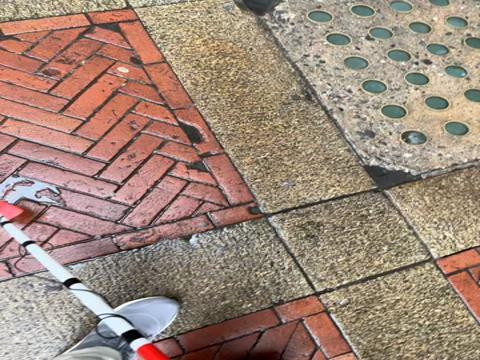

In [170]:
#inference
firstImage = Image.open('.content/customDatasetWithLabel/images/training/0@0_2023-03-23_15-38-19-4410_Brick.jpg')
firstImage

In [171]:
# prepare the image for the model
pixel_values = my_image_processor(firstImage, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)


torch.Size([1, 3, 512, 512])


In [172]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)


In [173]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 9, 128, 128])


In [174]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    #Changed to my own palette cuz why not
    return [[1,1,1], [31, 31, 31], [62, 62, 62], [93, 93, 93],
            [123, 123, 123], [154, 154, 154], [185,185, 185], [216, 216, 216],
            [247, 247, 247]]


In [176]:
predicted_segmentation_map = my_image_processor.post_process_semantic_segmentation(outputs, target_sizes=[firstImage.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)


[[1 1 1 ... 7 7 7]
 [1 1 1 ... 7 7 7]
 [1 1 1 ... 7 7 7]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


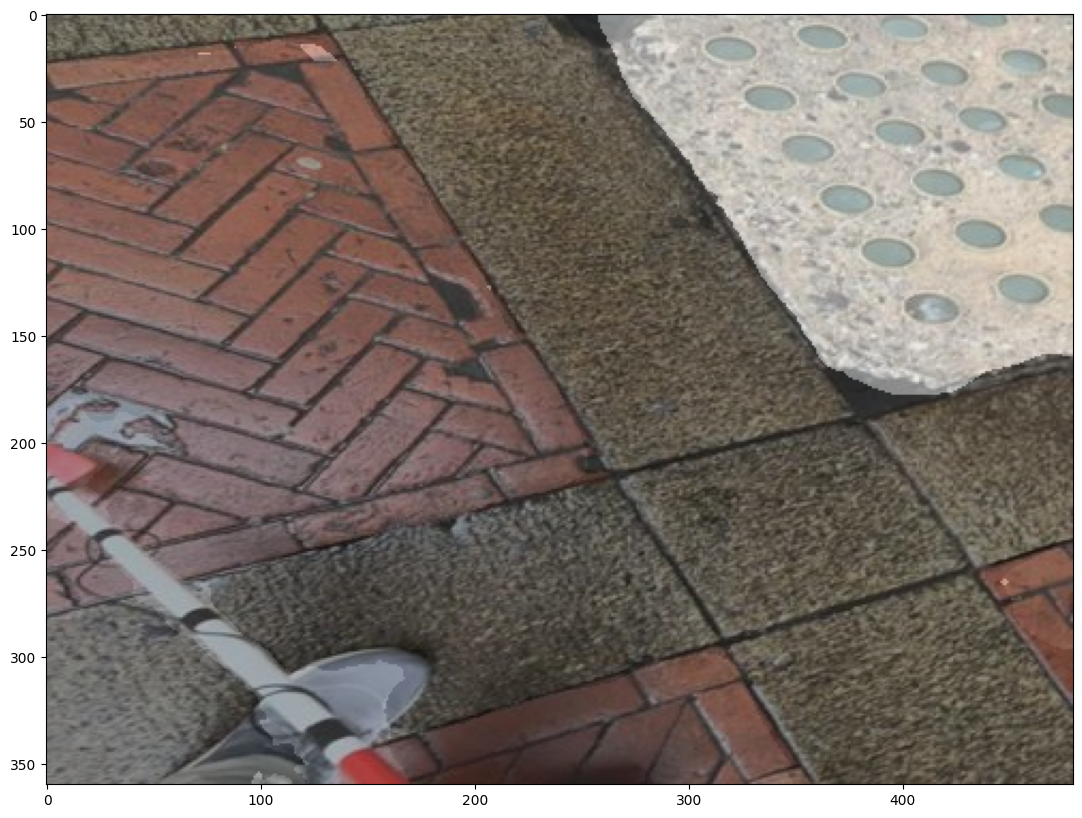

In [177]:
import matplotlib.pyplot as plt

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(firstImage) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()


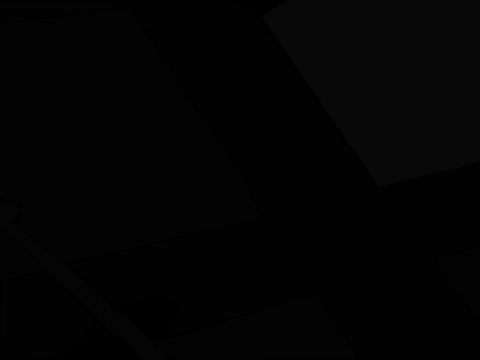

In [178]:
firstAnnotation = Image.open('.content/customDatasetWithLabel/annotations/training/0@0_2023-03-23_15-38-19-4410_Brick.png').convert("L")
firstAnnotation


Classes in this image: ['Manhole Cover', 'Concrete', 'Brick', 'Cellar door', None]


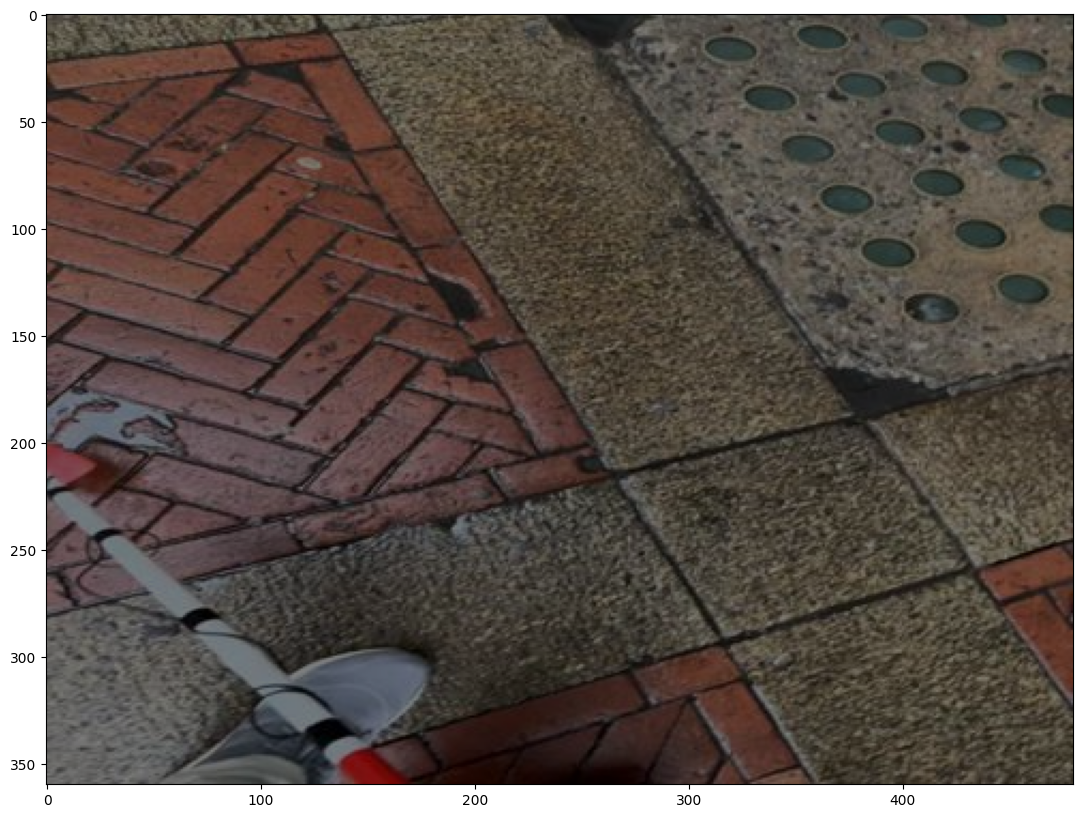

In [179]:
# convert map to NumPy array
firstAnnotation = np.array(firstAnnotation)
firstAnnotation[firstAnnotation == 0] = 255 # background class is replaced by ignore_index
firstAnnotation = firstAnnotation - 1 # other classes are reduced by one
firstAnnotation[firstAnnotation == 254] = 255

classes_map = np.unique(firstAnnotation).tolist()
unique_classes = [model.config.id2label[idx2] if idx2!=255 else None for idx2 in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((firstAnnotation.shape[0], firstAnnotation.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(firstImage) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()


In [180]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric.compute(
                  predictions=[predicted_segmentation_map],
                  references=[firstAnnotation],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )


In [181]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [182]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for my_id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][my_id],
                           metrics["per_category_accuracy"][my_id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])


mean_iou 0.9600386137316697
mean_accuracy 0.9783922343012073
overall_accuracy 0.9871863413907168
---------------------
per-category metrics:


,IoU,accuracy
other,0.962528,0.980987
Manhole Cover,0.980378,0.990934
Concrete,0.987148,0.996441
Brick,0.860455,0.925764
Cane,0.981118,0.991087
Subway grate,0.985360,0.992328
Dirt,0.977157,0.989470
Cellar door,0.946165,0.960129
Tactile pavement,NaN,NaN
